# Importing the data and selecting subset
The data is first imported from the SQLite file and converted into a pandas dataframe. After that, all N/A and duplicate records are dropped, and a the dataset is subsetted randomly. 

In [3]:
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect("./data/properties_cleaned.db")
df = pd.read_sql_query(f"SELECT * FROM properties", conn)
conn.close()

#['bedrooms', 'building_form', 'city', 'commercial_space',
# 'days_on_market', 'energy_efficient', 'energy_label', 'fixer_upper',
# 'has_balcony', 'has_garden', 'has_heat_pump', 'has_roof_terrace',
# 'has_solar_panels', 'latitude', 'living_area', 'longitude',
# 'national_monument', 'object_type', 'plot_area_m2', 'postcode4',
# 'price', 'province', 'publication_date', 'rooms', 'url', 'year_built',
# 'has_basement', 'has_attic', 'stories'],

df = df.dropna()
df = df.drop_duplicates()
#df = df.sample(n=10000, random_state=1)

# Select subset
df = df[['price', 'bedrooms', 'building_form', 
         #'city', 
         'commercial_space',
         'days_on_market', 
         'energy_efficient', 'energy_label', 'fixer_upper',
         'has_balcony', 'has_garden', 'has_heat_pump', 'has_roof_terrace',
         'has_solar_panels', 'latitude', 'living_area', 'longitude',
         'national_monument', 
         'object_type', 'plot_area_m2', #'postcode4',
         'province', 
         #'publication_date', 
         'rooms', 'year_built',
         'has_basement', 'has_attic', 'stories']]

# Preprocessing and analyzing the data prior to modeling
Before the model can be created, the data has to be preprocessed and analyzed for things such as multicollinearity.

## Converting datatypes
All columns have to be converted to the proper datatypes to allow modeling

In [4]:
# CATEGORY
df['building_form'] = df['building_form'].astype('category')
df['object_type'] = df['object_type'].astype('category')
df['province'] = df['province'].astype('category')

# Ordinal category for energy_label
df['energy_label'] = pd.Categorical(
    df['energy_label'],
    categories=['g', 'f', 'e', 'd', 'c', 'b', 'a'],
    ordered=True
)

# BOOL
df['has_balcony'] = df['has_balcony'].astype(bool)
df['has_garden'] = df['has_garden'].astype(bool)
df['has_heat_pump'] = df['has_heat_pump'].astype(bool)
df['has_roof_terrace'] = df['has_roof_terrace'].astype(bool)
df['has_solar_panels'] = df['has_solar_panels'].astype(bool)
df['has_basement'] = df['has_basement'].astype(bool)
df['has_attic'] = df['has_attic'].astype(bool)
df['fixer_upper'] = df['fixer_upper'].astype(bool)
df['energy_efficient'] = df['energy_efficient'].astype(bool)
df['commercial_space'] = df['commercial_space'].astype(bool)
df['national_monument'] = df['national_monument'].astype(bool)

# INT
df['rooms'] = df['rooms'].astype(int)
df['year_built'] = df['year_built'].astype(int)
df['living_area'] = df['living_area'].astype(int)
df['plot_area_m2'] = df['plot_area_m2'].astype(int)
df['days_on_market'] = df['days_on_market'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
df['stories'] = df['stories'].astype(int)

# FLOAT
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['price'] = df['price'].str.replace('€', '').str.replace('.', '').astype(float)

# print data types
print(df.dtypes)

price                 float64
bedrooms                int64
building_form        category
commercial_space         bool
days_on_market          int64
energy_efficient         bool
energy_label         category
fixer_upper              bool
has_balcony              bool
has_garden               bool
has_heat_pump            bool
has_roof_terrace         bool
has_solar_panels         bool
latitude              float64
living_area             int64
longitude             float64
national_monument        bool
object_type          category
plot_area_m2            int64
province             category
rooms                   int64
year_built              int64
has_basement             bool
has_attic                bool
stories                 int64
dtype: object


In [5]:
print(len(df))

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for specified columns
for col in ['bedrooms', 'living_area', 'plot_area_m2', 'rooms', 'year_built', 'stories', 'price']:
    df = remove_outliers_iqr(df, col)
print(len(df))

144662
120601


## Check for Multicolinearity
Multicollinearity doesnt impact rf, but important for interpretting 

In [6]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

numeric_vars = df.select_dtypes(include=['number']).drop(columns='price')
X = add_constant(numeric_vars)  # A constant is added
 
# Compute VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False)  # Sort by VIF values

print(vif_data)

          feature           VIF
0           const  17137.298515
7           rooms      5.631439
1        bedrooms      5.539352
4     living_area      2.866817
6    plot_area_m2      1.806202
9         stories      1.564229
5       longitude      1.239507
8      year_built      1.118871
3        latitude      1.117233
2  days_on_market      1.003158


The VIF values show signs of multicolliniearity for bedrooms and rooms. Therefore, the rooms variable will be converted to a non_bedroom_rooms variable. This will give the variable a different meaning, while still maintaining context.

In [7]:
if 'rooms' in df.columns:
    df['non_bedroom_rooms'] = df['rooms'] - df['bedrooms'].astype(int)
    df = df.drop(columns=['rooms'])

# Random Forest Model
Random Forest Model

## Initial Model

In [8]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y = df['price']
X = pd.get_dummies(df.drop(columns=['price']), drop_first=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print("MAE: {:.2f} ± {:.2f}".format(np.mean(mae_scores), np.std(mae_scores)))
print("RMSE: {:.2f} ± {:.2f}".format(np.mean(rmse_scores), np.std(rmse_scores)))
print("R^2: {:.3f} ± {:.3f}".format(np.mean(r2_scores), np.std(r2_scores)))

MAE: 36259.33 ± 54.34
RMSE: 50965.44 ± 111.53
R^2: 0.857 ± 0.001


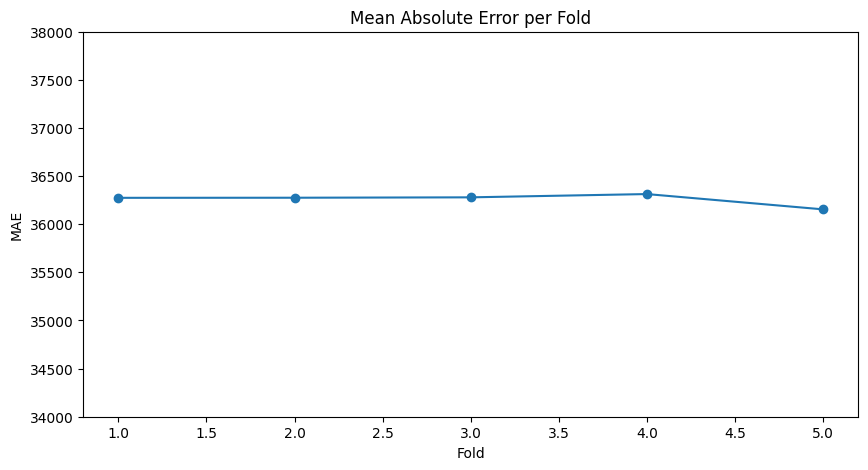

In [19]:
# Creat a plot showing the mae per fold
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), mae_scores, marker='o', label='MAE per fold')
plt.title('Mean Absolute Error per Fold')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.ylim(bottom=34000, top=38000)
plt.show() 

In [35]:
#Test prediction
property = {
    'bedrooms': 2,
    'building_form': 'house',
    'commercial_space': False,
    'days_on_market': 0,
    'energy_efficient': True,
    'energy_label': 'c',
    'fixer_upper': False,
    'has_balcony': False,
    'has_garden': True,
    'has_heat_pump': False,
    'has_roof_terrace': False,
    'has_solar_panels': False,
    'latitude': 50.85996627807617,
    'living_area': 125,
    'longitude': 5.781289577484131,
    'national_monument': False,
    'object_type': 'house',
    'plot_area_m2': 492,
    'province': 'Limburg',
    'rooms': 4,
    'year_built': 1956,
    'has_basement': True,
    'has_attic': False,
    'stories': 2
}

property_df = pd.DataFrame([property])
property_df = pd.get_dummies(property_df, drop_first=True)

# Ensure the property_df has the same columns as X
missing_cols = set(X.columns) - set(property_df.columns)
for col in missing_cols:
    property_df[col] = 0
property_df = property_df[X.columns]  # Reorder columns to match X
predicted_price = rf.predict(property_df)[0]
print(f"Predicted price for the property: €{predicted_price:,.2f}")

Predicted price for the property: €398,815.00


## Feature Importance

### SHAP

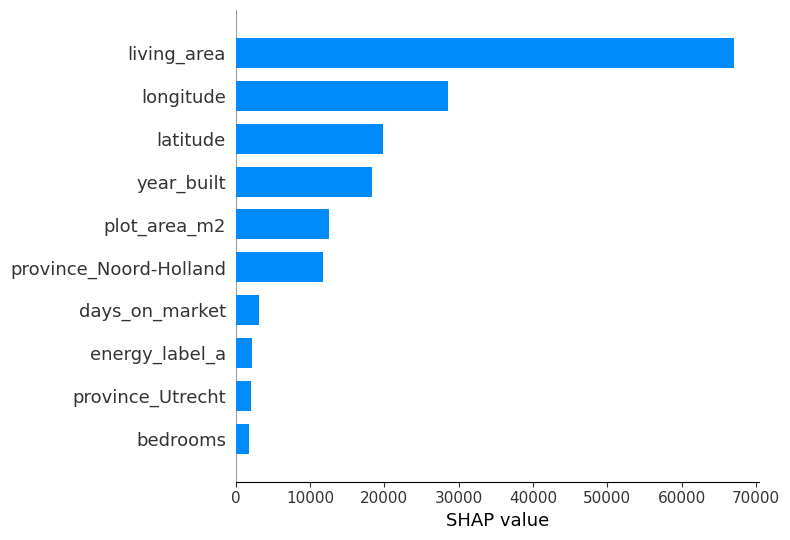

In [49]:
import shap
import numpy as np

subset_idx = np.random.choice(X.index, size=1000, replace=False)
X_subset = X.loc[subset_idx]
y_subset = y.loc[subset_idx]

rf.fit(X_subset, y_subset)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_subset)

# Get mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top10_idx = np.argsort(mean_abs_shap)[-10:][::-1]
top10_features = X_subset.columns[top10_idx]


# Plot SHAP Values for the top 10 features
shap.summary_plot(shap_values[:, top10_idx], X_subset.iloc[:, top10_idx], plot_type="bar", show=False)
plt.xlabel("SHAP value")
plt.tight_layout()
plt.savefig("./plots/rf_shap_10.png", dpi=300, bbox_inches='tight')
plt.show()
